# Association Rules - Instacart Market Basket Analysis

*Disclaimer: this notebook was originally run on Google Colab.*

This notebook is aimed at exploring the extensive dataset included in the [Instacart Market Basket Analysis competition](https://www.kaggle.com/c/instacart-market-basket-analysis), hosted at Kaggle. The dataset contains over 3 million grocery transactions, comprising a huge variety of products from different departments. The competition dealt with predicting which products that were order earlier by a client would be added to their next order. In this exercise, I am instead focusing on data exploration and the generation of association rules, which are informative for sales strategies such as those delivered by recommendation systems. Association rules are one of the four fundamental machine learning tasks, alongside regression, classification and clustering. I will generate rules based on two data collections: purchase habits (day and time, interval between orders...) and product association (which products tend to be sold together).

The data can be obtained from the competition page linked above. Kaggle encourages those interested in obtaining data from the platform to do so by signing up and downloading according to their guidelines.

## 1 Installing and loading dependencies

I will use the `apyori` library to generate association rules, therefore I am installing it first.


In [1]:
!pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5975 sha256=7072635112d1c3d83daa97442d903c28c7dad2387aeade3df429daaa068a9604
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


Loading the dependencies...

In [0]:
import os
import pandas as pd
import numpy as np
from apyori import apriori
from collections import Counter
from datetime import datetime
from itertools import combinations
import matplotlib.pyplot as plt

## 2 Getting the data

To avoid uploading the data to the Google Colab environment everytime, I hosted them in my Google Drive account, from where I am retrieving them. (I recommend those interested in running this notebook do the same.)

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!mkdir data

In [0]:
!cp /gdrive/My\ Drive/Data\ Science/Udemy/Regras\ de\ Associação/*.csv data

In [0]:
os.chdir('data')

In [7]:
os.listdir()

['order_products__prior.csv',
 'aisles.csv',
 'products.csv',
 'orders.csv',
 'departments.csv']

The original dataset contains three `order_products` csv files, but I will be relying only on the `prior` version. This file contains all transactions (one product per row) that are to be considered features for training the model in the original task of the competition.

## 3 Loading and inspecting the files

I will load all 5 files in separate dataframes and inspect its contents to get familiarity with the data.

### `aisles.csv`

In [0]:
aisles = pd.read_csv('aisles.csv')

In [9]:
aisles.dtypes

aisle_id     int64
aisle       object
dtype: object

This tells me that this dataframe contains two columns. The first, `aisle_id`, contains integers, which suggests this is a primary key, and the second, `aisle`, contains objects, possibly the name or description of the corresponding id. 

I will now inspect the content.

In [10]:
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


It seems indeed that the id column contains primary keys for each aisle, numbered sequentially from 1. The other column contains the aisle names. There are 134 aisles in total.

In [11]:
aisles.isna().sum(axis = 0)

aisle_id    0
aisle       0
dtype: int64

There is no empty value in this dataframe

### `departments.csv`

In [0]:
departments = pd.read_csv('departments.csv')

In [13]:
departments.dtypes

department_id     int64
department       object
dtype: object

There is also an id and a description.

In [14]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


There are 21 departments, numbered sequentially. I believe that each department contains one or more aisles.

### `products.csv`

In [0]:
products = pd.read_csv('products.csv')

In [16]:
products.dtypes

product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object

Each product also contains an id, but this dataframe also locates each of them to an aisle and to a department.

In [17]:
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


There are 49688 products, each one apparently identified by a unique id. As before, these ids are given sequentially starting from 1. The corresponding aisle and department is indicated by their ids, which names can be retrieved from the previous dataframes.

In [18]:
products.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


All numeric columns have the same count, which is equal to the number of rows, indicating that there are no missing values. The minimum is 1 and the maximum is equal to the last entry for each category (product, aisle or department), which suggest, for `product_id`, that all ids are indeed unique, and given sequentially, and for `aisle_id` and `department_id`, that they are consistent with the previous, corresponding, dataframes.

In [19]:
len(set(products.product_id))

49688

This confirms that all entries in `product_id` are unique.

In [20]:
products.isna().sum(axis = 0)

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

And this confirms that there are no missing values.

### `orders.csv`

In [0]:
orders = pd.read_csv('orders.csv')

In [22]:
orders.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

This dataframe seems to link the users to their orders. The next visualization will let me describe it better.

In [23]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


It seems the users are listed sequentially, starting from 1. 

Each row corresponds to an order. `order_id` does not seem to be sequential to each user. I wondered if they were given cronologically, but that does not seem to be the case, since the third order for the first user has an id value lower than the second, which in turn is higher than the first. I hope this realization proves to be irrelevant! 

`eval_set` will be evaluated below. 

`order_number` refers to that particular user, and seems to be given sequentially. 

`order_dow` is, according to the documentation, the day of the week. 

`order_hour_of_day` is self-explanatory. 

`days_since_prior_order` indicates the interval between two consecutive orders; it seems for the first order for a given user we are given `NaN`, which makes sense, since there was no order previous to that one. The values in this column are floats, but from this small inspection, it seems they could have been represented as integers.

The dataframe contains 3,421,083 rows, indicating this number of orders.

In [24]:
orders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

The column `eval_set` clarifies if that order belongs to the *prior*, *train* or *test* data split. The majority (3,214,874 orders) are from the *prior* split, which I will be considering in this analysis. Therefore, let me update the dataframe to contain only these orders. Since I will not need this column anymore, I will also drop it.

In [25]:
orders = orders[orders.eval_set == 'prior']
orders.drop('eval_set', axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.008665e+06
mean,1.710827e+06,1.029701e+05,1.719107e+01,2.776364e+00,1.344347e+01,1.070724e+01
std,9.875206e+05,5.953411e+04,1.779950e+01,2.041806e+00,4.226246e+00,8.954180e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.556832e+05,5.138500e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.711120e+06,1.026620e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.566034e+06,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


All columns have the same count (which is equal to the number of rows in the *prior* split, indicating no missing values), except column `days_since_prior_order`. The difference is probably due to those `NaN` values. 

If `user_id` is given sequentially, there are 206,209 users; we will confirm this below. 

`order_number` goes from 1 to 99, meaning all clients included purchased at least once, and none made more than 99 orders. 

`order_dow` contains values from 0 to 6, corresponding to the 7 days of the week. 

`order_hour_of_day` goes from 0 to 23, which corresponds to the 24 hours of a day. 

`days_since_prior_order` goes from 0 to 30, meaning that some orders were made in the same day of the previous order, while the longest interval is 30 days.

In [27]:
len(set(orders.user_id))

206209

There are indeed 206,209 users.

In [28]:
orders.isna().sum(axis = 0)

order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Only `days_since_prior_order` contains missing values. The number of missing values is equal to the number of users, due to the fact that all users have a first order.

Let me now look at these rows closer.

In [29]:
orders.loc[orders.days_since_prior_order.isna()]

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
11,2168274,2,1,2,11,NaN
26,1374495,3,1,1,14,NaN
39,3343014,4,1,6,11,NaN
45,2717275,5,1,3,12,NaN
...,...,...,...,...,...,...
3420930,969311,206205,1,4,12,NaN
3420934,3189322,206206,1,3,18,NaN
3421002,2166133,206207,1,6,19,NaN
3421019,2227043,206208,1,1,15,NaN


They seem indeed to be the first orders (`order_number = 1`) of each user; notice that each row corresponds to a new user in sequential order.

Now, since data is much easier to interpret if shown in figures, I will make some plots.

First I will inspect whether the `order_number` is indeed sequential to each user. Since there are too many orders, I will check only the first 100.

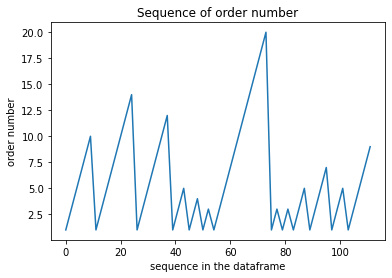

In [30]:
plt.plot(orders.order_number[:100]);
plt.title('Sequence of order number');
plt.xlabel('sequence in the dataframe');
plt.ylabel('order number');


Yes, `order_number` starts from 1 and increases by 1 until it drops back to 1, when a new user is listed I presume.

Now I will check the distribution of values in `order_dow` and `order_hour_of_day`.

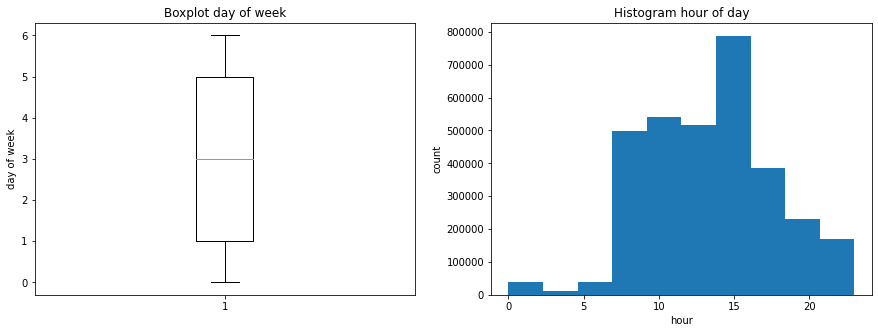

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].boxplot(orders.order_dow);
ax[0].set_title('Boxplot day of week');
ax[0].set_ylabel('day of week');
ax[1].hist(orders.order_hour_of_day);
ax[1].set_title('Histogram hour of day');
ax[1].set_xlabel('hour');
ax[1].set_ylabel('count');

The count of days of week (which equals the number of orders in each such day) is quite well distributed, with median equals to 3.

During the day, very few orders are place from 0 to 7 hours. From 8 until 15, the number is quite high and stable. From 15 to 17, there is a peak, then afterwards the number lowers steadily.

Finally, let me inspect `days_since_prior_order` closer. I will also plot only the first 100 values. I am adding 1 to the value so that I can differentiate a 0 (which will become a 1) from NaN (which will not be shown).

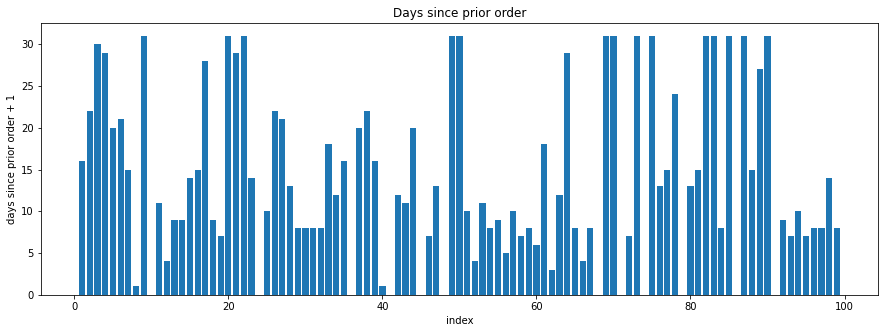

In [32]:
plt.figure(figsize = (15, 5));
plt.bar(range(100), orders.days_since_prior_order[:100]+1);
plt.title('Days since prior order');
plt.xlabel('index');
plt.ylabel('days since prior order + 1');

I can now check that the series start with a NaN representing the first order of the first user, which is succeeded by several intervals of variable length for that user, then a second NaN from the second user, and so on. The values peak at 31, which equals 30 days of interval, as previously observed.

### `order_products(__prior).csv`

As mentioned before, we will be working only with orders belonging to the *prior* evaluation set.

In [0]:
order_products = pd.read_csv('order_products__prior.csv')

In [34]:
order_products.dtypes

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

This dataframe contains 4 columns, and all contain integer values.

In [35]:
order_products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


This dataframe discriminates what each order contains. 

It seems that each row contains one product from the order specified in the `order_id` column. The `order_id` value is repeated for all products that it contains. 

`product_id` is the identifier that can be linked to the product name (and its assorted aisle and department) in the `products` dataframe.

`add_to_cart_order` seems to be numbered sequentially to reflect what its name states. 

`reordered` indicates whether the product in that row is being purchased for the first time (if 0) by the user linked to that `order_id`, or if it is being reordered (1). In the second case, this is an indicator of product fidelity.

This dataframe contains 32,434,489 entries, which is a considerably large purchase history.

In [36]:
len(set(order_products.order_id))

3214874

The dataframe contains data for 3,214,874 orders, which equals the number of rows in the `orders` dataframe. This is an indication that all orders present there are present here.

In [37]:
order_products.isna().sum(axis = 0)

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

None of the columns contain missing values. Given such a large dataset, wow for those responsible for gathering the data!


## 4 Data exploration

Now let me delve deeper into the dataframes containing order information.

### `orders` dataframe

I will start with the dataframe linking users to their respective orders, focusing on count distribution. This kind of statistical exploration is useful for categorizing the features in the dataset, which is necessary for creating association rules. Later on, I will use this dataframe as basis for association rules generation, so I will first generate a copy of it that I will update for the algorithm along the way.



In [0]:
orders_apriori = orders.copy()

#### User

Let me check how many orders and how many products each user made.

For orders, I can group the `orders` dataframe by `user_id`, then get the maximum value for `order_number`.

In [0]:
orders_by_user = orders.groupby('user_id')['order_number'].max()

For products, I need to merge `orders` with `order_products`. I am first retrieving only the columns I need from both dataframes. For `order_products`, I am grouping the resulting columns by `order_id`, then getting the maximum value in `add_to_cart_order`, which will give me the size of that order. Then I am joining both dataframes by `order_id`.

In [0]:
products_by_user = orders[['order_id', 'user_id']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
    on = 'order_id')

Now I can update this variable to contain the resulting dataframe grouped by `user_id` (I am dropping `order_id` since it will not be informative any further), then getting `order_size` and summing the values. This will give me how many products each user purchased.

In [0]:
products_by_user = products_by_user.drop('order_id', axis = 1).groupby('user_id')['order_size'].sum()

Now I will plot 2 histograms side by side, one for orders, the other for products. Since the number of orders is limited to a quite narrow range, I will set the number of bins equal to this number, so that each bin will represent an integer in this interval. The number of products is much more variable, so to get quite equivalent distributions, I am setting the number of bins to 100.

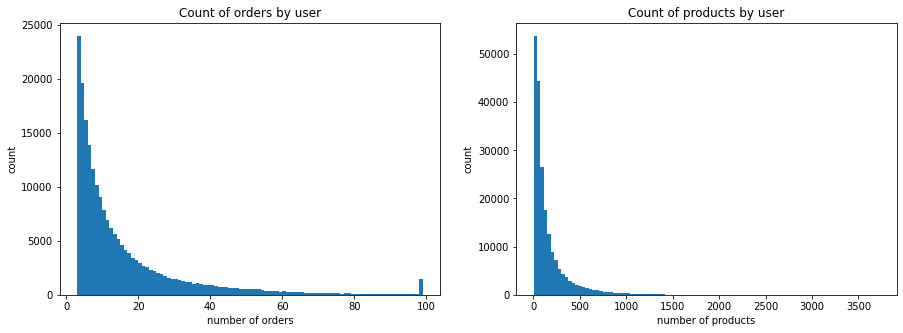

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(orders_by_user, bins = max(orders_by_user) - min(orders_by_user));
ax[0].set_title('Count of orders by user');
ax[0].set_xlabel('number of orders');
ax[0].set_ylabel('count');
ax[1].hist(products_by_user, bins = 100);
ax[1].set_title('Count of products by user');
ax[1].set_xlabel('number of products');
ax[1].set_ylabel('count');

First I should notice that both distributions are regular, resembling a perfect exponential distribution. This is a powerful indication that both variables in this case are indeed modeled by exponential distributions. It also attests to the power of large datasets in showcasing statistical properties such as probability distributions. 

One thing caught my attention in the first plot. `number_of_orders = 99` shows a peak. Given the exoterism of this specific value, I imagine that the reason is that `number_of_orders` was capped at 99 in the dataset, meaning that it actually stands for 99+, accumulating all orders larger than 98.

Besides, when comparing both distributions, I notice that the counts of `number_of_orders` decay much slower than `number_of_products`. That might be an indication that users that make more orders tend to purchase less products in each order.

Now, for my *apriori* dataframe, since I cannot categorize features `user_id` and `order_id`, I am dropping them.

In [0]:
orders_apriori.drop(['user_id', 'order_id'], axis = 1, inplace = True)

#### Order number

I will here check the count of order numbers. Differently from the previous analysis, I am not considering the total number of orders by user, but instead, how many times "`order_number` equals to any number" occured. 

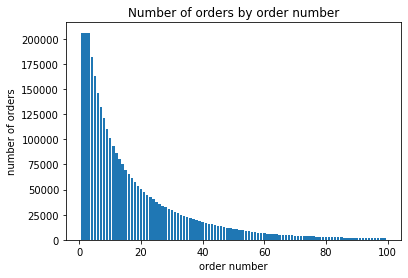

In [44]:
orders_by_order_number = orders.order_number.value_counts()
plt.bar(orders_by_order_number.index, orders_by_order_number);
plt.title('Number of orders by order number');
plt.xlabel('order number');
plt.ylabel('number of orders');

There seems to be a plateau in the very first bars. We can check the value counts to investigate further.

In [45]:
orders_by_order_number[:5]

1    206209
2    206209
3    206209
4    182223
5    162633
Name: order_number, dtype: int64

This means that `order_number` equals to 1, 2 and 3 are all equal to the same value, 206,209. We should here also remember that the number of users in the dataset is also equal to this value. This means that all users made order numbers 1, 2 or 3, or in other words, that all users purchased at least 3 times.

Now for updating the *apriori* dataframe, I believe this feature might have some relation to the others, so I will categorize it. Since no clear division can be derived from the barplot above as the distribution is continuous, I will set categories comprising "somewhat uniform" ranges 1-3, 4-5, 5-10, 10-20, 20-40, 40-60 and 60+.

In [0]:
def order_number_categorical(order_number):
    if order_number in range(3):
        return 'order_number_1-3'
    if order_number in range(3, 5):
        return 'order_number_4-5'
    if order_number in range(5, 10):
        return 'order_number_6-10'
    if order_number in range(10, 20):
        return 'order_number_11-20'
    if order_number in range(20, 40):
        return 'order_number_21-40'
    if order_number in range(40, 60):
        return 'order_number_41-60'
    if order_number >= 60:
        return 'order_number_60+'

In [0]:
orders_apriori.order_number = orders_apriori.order_number.map(order_number_categorical) 

#### Day of week

Likewise I did for user, I will also inspect the number of orders and the number of products purchased by day of week.

In [0]:
orders_by_dow = orders.order_dow.value_counts()
products_by_dow = orders[['order_id', 'order_dow']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
    on = 'order_id')
products_by_dow = products_by_dow.drop('order_id', axis = 1).groupby('order_dow')['order_size'].sum()

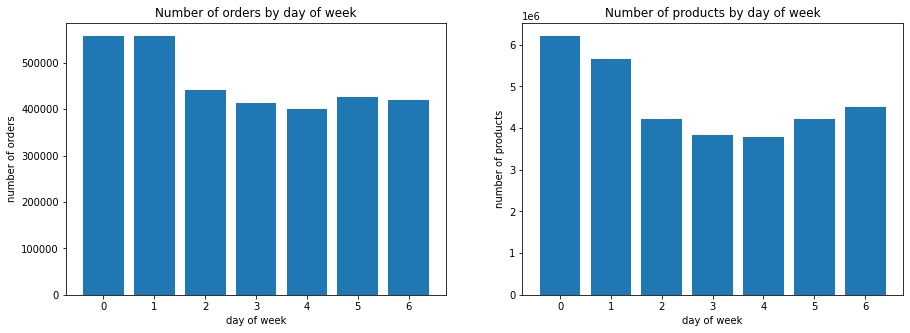

In [49]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].bar(orders_by_dow.index, orders_by_dow);
ax[0].set_title('Number of orders by day of week');
ax[0].set_xlabel('day of week');
ax[0].set_ylabel('number of orders');
ax[1].bar(products_by_dow.index, products_by_dow);
ax[1].set_title('Number of products by day of week');
ax[1].set_xlabel('day of week');
ax[1].set_ylabel('number of products');

The documentation does not disclaim what each dow number stands for, but we can notice that both plots peak at 0 and 1. Although this is a weird classification, I will henceforth consider that these values represent Saturday and Sunday, respectively, given the counts shown above.

The number of orders on Saturday and Sunday is very similar, being the largest throughout the week. Although the number of products is also largest on weekends, more products are sold on Saturday. Both number of orders and products is quite uniform on weekdays, tending to be smaller on Tuesday and Wednesday.

From this analysis, I will update the *apriori* dataframe so that the `dow` feature indicates `weekend` or `weekday`.

In [0]:
def dow_categorical(dow):
    if dow in [0, 1]:
        return 'weekend'
    else:
        return 'weekday'

In [0]:
orders_apriori.order_dow = orders_apriori.order_dow.map(dow_categorical) 

#### Hour of day

I will also consider the number of orders and the number of products purchased by hour.



In [0]:
orders_by_hour = orders.order_hour_of_day.value_counts()

products_by_hour = orders[['order_id', 'order_hour_of_day']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
    on = 'order_id')
products_by_hour = products_by_hour.drop('order_id', axis = 1).groupby('order_hour_of_day')['order_size'].sum()

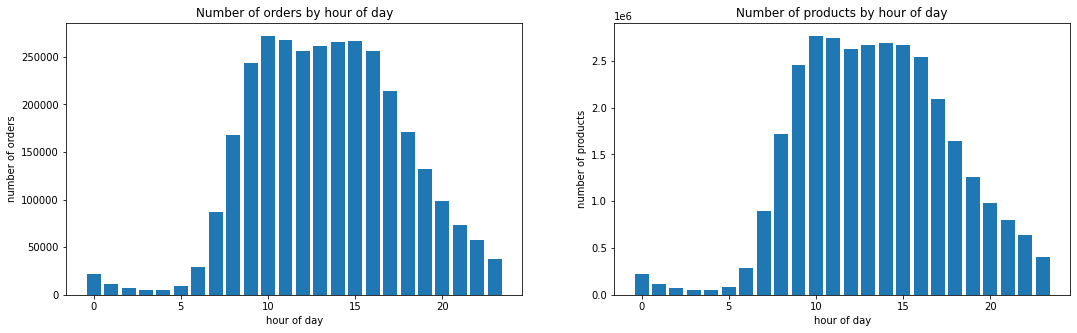

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (18, 5));
ax[0].bar(orders_by_hour.index, orders_by_hour);
ax[0].set_title('Number of orders by hour of day');
ax[0].set_xlabel('hour of day');
ax[0].set_ylabel('number of orders');
ax[1].bar(products_by_hour.index, products_by_hour);
ax[1].set_title('Number of products by hour of day');
ax[1].set_xlabel('hour of day');
ax[1].set_ylabel('number of products');

Here, both distributions are very similar, suggesting that the order sizes do not vary in regards to hour. The number of orders or products is smallest from 0 to 7 hours, when it starts to increase steadily until 10 o'clock, staying high until 16. Then, it decreases steadily until the end of the day.

Given this information, I will consider several intervals to categorize `hour_of_day`, based on their distribution uniformity: 0-6, 7, 8, 9, 10-16, 17, 18, 19, 20, 21, 22, 23.

In [0]:
def hour_categorical(hour):
    if hour in range(7):
        return 'early_hours'
    if hour in range(7, 10):
        return 'hour_' + str(hour)
    if hour in range(10, 17):
        return 'peak_hours'
    if hour in range(17, 24):
        return 'hour_' + str(hour)

In [0]:
orders_apriori.order_hour_of_day = orders_apriori.order_hour_of_day.map(hour_categorical) 

#### Interval between orders

I have seen previously that this interval tops at 30 days. Therefore, I will plot a histogram with 30 bins.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


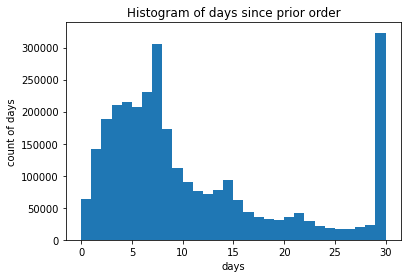

In [56]:
plt.hist(orders.days_since_prior_order, bins = 30);
plt.title('Histogram of days since prior order');
plt.xlabel('days');
plt.ylabel('count of days');

Here we can see some interesting patterns.

First, most reorders are placed within the first few days.

Second, there are peaks at 7, 14 and 21, meaning that people tend to reorder on a weekly basis.

Third, the largest peak is at the maximum value, 30. Just like in `order_number`, it seems this variable is capped at 30. Also, since this is the largest count, several orders are placed from one month up.

Based on these characteristics, I will categorize this feature according to the following pattern. First, if the value is `NaN`, it will be classified as *first order*, as is the case. Second if the values is within the weekly peaks, it will be classified accordingly. The interval equals to 30+ will also receive its own category. All other values will be considered *others*.

In [0]:
def interval_categorical(interval):
    if np.isnan(interval):
        return 'first_order'
    elif interval in [7, 14, 21]:
        return 'interval_weekly'
    elif interval == 30:
        return 'interval_30+'
    else:
        return 'interval_others'

In [0]:
orders_apriori.days_since_prior_order = orders_apriori.days_since_prior_order.map(interval_categorical)

The work here is done, so let me inspect briefly the resulting *apriori* dataframe.

In [59]:
orders_apriori

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,weekday,hour_8,first_order
1,order_number_1-3,weekday,hour_7,interval_others
2,order_number_4-5,weekday,peak_hours,interval_weekly
3,order_number_4-5,weekday,hour_7,interval_others
4,order_number_6-10,weekday,peak_hours,interval_others
...,...,...,...,...
3421077,order_number_6-10,weekday,peak_hours,interval_others
3421078,order_number_11-20,weekday,hour_18,interval_others
3421079,order_number_11-20,weekday,peak_hours,interval_30+
3421080,order_number_11-20,weekend,peak_hours,interval_others


### `order_products` dataframe

The exploration of this dataframe might give me some insights useful to interpret the association rules generated.

#### Reordered products

Since this dataframe contains `product_id`, which is not much informative, I will first generate a dictionary to convert id to name. Then, I will copy the dataframe to a new variable so that the original information remains intact, and include the product names.

In [60]:
products_id_to_name = {k: v for k, v in zip(products.product_id, products.product_name)}
order_products_names = order_products.copy()
order_products_names['product_name'] = order_products_names.product_id.map(lambda x: products_id_to_name[x])
order_products_names

,order_id,product_id,add_to_cart_order,reordered,product_name
0,2,33120,1,1,Organic Egg Whites
1,2,28985,2,1,Michigan Organic Kale
2,2,9327,3,0,Garlic Powder
3,2,45918,4,1,Coconut Butter
4,2,30035,5,0,Natural Sweetener
...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter
32434486,3421083,4600,8,0,All Natural French Toast Sticks
32434487,3421083,24852,9,1,Banana


To count how many time each product was purchased the first time or reordered, I will use function `crosstab` from `pandas`. This function will sum the co-occurrences of each category in `product_name` and the `reordered` feature.

In [0]:
reorder_proportion = pd.crosstab(order_products_names.product_name, order_products_names.reordered)

I can now check which products were first-purchased or reordered most.

In [62]:
reorder_proportion.sort_values(by = 0, ascending = False)

reordered,0,1
product_name,,
Banana,73956,398609
Bag of Organic Bananas,63537,315913
Organic Strawberries,58838,205845
Organic Baby Spinach,55037,186884
Large Lemon,46402,106255
...,...,...
Brut Prosecco,1,0
Smooth & Silky Head and Shoulders Smooth & Silky 2-in-1 Dandruff Shampoo + Conditioner 13.5 Fl Oz Female Hair Care,1,0
Gluten Free Pantry Sugar Cookie Mix,1,1


The two top first-purchases are bananas, following by other produce. At the bottom, some products were purchased only once by some single user.

In [63]:
reorder_proportion.sort_values(by = 1, ascending = False)

reordered,0,1
product_name,,
Banana,73956,398609
Bag of Organic Bananas,63537,315913
Organic Strawberries,58838,205845
Organic Baby Spinach,55037,186884
Organic Hass Avocado,43453,170131
...,...,...
Decorating Green Cake Icing,21,0
Lemon Ice Tea Liquid,4,0
"Decorating Gel, Red",7,0


The ordered champions are also bananas, followed again by strawberries and spinach. People really tend to enjoy them after first try. At the bottom, some products were never reordered.

Now I will check, for each product total, the proportion of their orders that were first-purchases or reorders.

In [0]:
reorder_proportion['total'] = reorder_proportion.sum(axis = 1)
reorder_proportion['0.perc'] = reorder_proportion[0]/reorder_proportion['total']
reorder_proportion['1.perc'] = reorder_proportion[1]/reorder_proportion['total']

In [65]:
reorder_proportion.sort_values(by = ['0.perc', 'total'], ascending = False)[['0.perc', 'total']]

reordered,0.perc,total
product_name,,
Vicks DayQuil and NyQuil Cold & Flu Relief Combo,1.000000,88
Organic Castor Oil Skin Care,1.000000,67
Organic Whole Rosemary,1.000000,63
Lemon Verbena Scent Glass Cleaner,1.000000,53
Organic Lemongrass,1.000000,52
...,...,...
Soy Powder Infant Formula,0.085714,35
Chocolate Love Bar,0.079208,101
Orange Energy Shots,0.076923,13


The top results mean that, all times these products were ordered, it was a first-purchase (since the value is equal to 100%). Since the number of purchases is relatively high, it seems people do tend to dislike them after first try.

At the bottom, we see those products that tend not to be first-purchases, meaning that users tend to like them after first try.

In [66]:
reorder_proportion.sort_values(by = ['1.perc', 'total'], ascending = False)[['1.perc', 'total']]

reordered,1.perc,total
product_name,,
Raw Veggie Wrappers,0.941176,68
Serenity Ultimate Extrema Overnight Pads,0.931034,87
Orange Energy Shots,0.923077,13
Chocolate Love Bar,0.920792,101
Soy Powder Infant Formula,0.914286,35
...,...,...
Vitality Chicken Breasts with Flaxseed & Vitamins Dog Treats,0.000000,1
Vitamin D Gummies,0.000000,1
Wicked Good No-Fry Wing Marinade,0.000000,1


As expected, this table is the complement of the previous, meaning the products in the bottom there are the top here. From all times they were purchased, the top 5 products were reorders more than 91% of the time.

The products in the bottom were purchased only once. From their names, I would conclude that not all eccentricity has a market demand... The retailer would do good not repurchasing these products themselves.

Finally, we can take advantage of this dataframe to check which products were purchased most or least in total.

In [67]:
reorder_proportion.total.sort_values(ascending = False)

product_name
Banana                                                                                 472565
Bag of Organic Bananas                                                                 379450
Organic Strawberries                                                                   264683
Organic Baby Spinach                                                                   241921
Organic Hass Avocado                                                                   213584
                                                                                        ...  
Lndbrg White Quinoa 16 Z                                                                    1
Homestlye Cornbread Stuffing                                                                1
Indoor & Outdoor Allergies, Allergy & Congestion, 24 Hour, Extended Release Tablets         1
Orange Recharge                                                                             1
Vitamin D Gummies                              

Produce is the winner, and bananas are in high demand, selling around 4 times more than the third place! On the other hand, no one seems to want or like those gummies...

#### Products listed but not bought

Did any product perform even worst than the vitamin D gummies? Let me generate a list with the unique `product_id`s in this dataframe, then compare with the information in the `products` dataframe.

In [68]:
products_bought = sorted(order_products.product_id.unique())
print(len(products_bought), len(products))

49677 49688


11 products were never purchased. I will now retrieve their ids then get their names using the previously generated dictionary.

In [69]:
products_not_bought = list(products.product_id[~products.product_id.isin(products_bought)])
[products_id_to_name[product] for product in products_not_bought]

['Protein Granola Apple Crisp',
 'Wasabi Cheddar Spreadable Cheese',
 'Unpeeled Apricot Halves in Heavy Syrup',
 'Chocolate Go Bites',
 'Non-Dairy Coconut Seven Layer Bar',
 'Water With Electrolytes',
 'Ultra Sun Blossom Liquid 90 loads Fabric Enhancers',
 'Sweetart Jelly Beans',
 '12 Inch Taper Candle White',
 'Single Barrel Kentucky Straight Bourbon Whiskey',
 'Pure Squeezed  Lemonade']

Who had the idea to make wasabi cheddar spreadable cheese anyway?

I would also like to check if any product bought is not in the product list (`products` dataframe).

In [70]:
products_not_registered = list(pd.Series(products_bought)[~pd.Series(products_bought).isin(products.product_id)])
print(len(products_not_registered), products_not_registered)

0 []


None! Whoever assembled these datasets was very careful!

#### Order sizes

Here I want to check how many times each order size occurs. I can get this by grouping the dataframe by `order_id`, then getting the maximum value in `add_to_cart_order`.

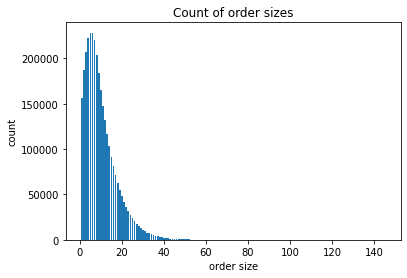

In [71]:
cart_size = order_products.groupby('order_id')['add_to_cart_order'].max()
cart_size = cart_size.value_counts()
plt.bar(cart_size.index, cart_size);
plt.title('Count of order sizes');
plt.xlabel('order size');
plt.ylabel('count');

Most orders are quite small, having less than 20 products. Yet, very few are considerably large. I will inspect the actual values.

In [72]:
cart_size

5      228330
6      227675
4      222081
7      220006
3      207027
        ...  
112         1
105         1
94          1
90          1
145         1
Name: add_to_cart_order, Length: 113, dtype: int64

It is curious that the sizes 4 to 7 tend to be similarly common. The largest size is apparently 145, which occurred only once.

#### Products most frequently put first in the cart

I will first ask for a crosstab with `product_name` and `add_to_cart_order`, then print the sorted results for the top 5 products put in the cart first to fifth.

In [73]:
add_to_cart = pd.crosstab(order_products_names.product_name, order_products_names.add_to_cart_order)
for i in range(1, 6):
    print('ORDER = ', i)
    print(add_to_cart.sort_values(by = i, ascending = False)[i][:5])
    print('\n')

ORDER =  1
product_name
Banana                    110916
Bag of Organic Bananas     78988
Organic Whole Milk         30927
Organic Strawberries       27975
Organic Hass Avocado       24116
Name: 1, dtype: int64


ORDER =  2
product_name
Banana                    80432
Bag of Organic Bananas    64337
Organic Strawberries      29754
Organic Hass Avocado      26517
Organic Baby Spinach      25025
Name: 2, dtype: int64


ORDER =  3
product_name
Banana                    58577
Bag of Organic Bananas    48972
Organic Strawberries      27809
Organic Baby Spinach      24297
Organic Hass Avocado      24212
Name: 3, dtype: int64


ORDER =  4
product_name
Banana                    43653
Bag of Organic Bananas    36955
Organic Strawberries      25242
Organic Baby Spinach      22733
Organic Hass Avocado      21001
Name: 4, dtype: int64


ORDER =  5
product_name
Banana                    33647
Bag of Organic Bananas    28897
Organic Strawberries      22137
Organic Baby Spinach      20308
Organic Has

It is not only that people like bananas, it is also that they are the most common product put from first to fifth in their carts. The other top positions are strawberries, spinach and avocado, also reflecting their total purchase amounts, with one curious exception: the third product put first in the cart is milk.

These results are not that surprising. Since most orders tend to have less than 20 products, it is expected that the most regularly purchased products would be among the first products added to the cart.

## 5 Association rules

So finally here we are!

As mentioned in the introduction, I will build rules for two data collections. The first one is the `orders_apriori` dataframe designed above, reflecting purchase habits. The second will generate associations among the products themselves.

### Purchase habits

For this task, I will take advantage of the `apyori` library. The method `apriori` receives the transactional information in list format, so I will convert the `orders_apriori` dataframe accordingly.

In [0]:
transactions = []
for i in range(orders_apriori.shape[0]):
    transactions.append([str(orders_apriori.values[i, j]) for j in range(orders_apriori.shape[1])])

For the very first try, I will choose the parameters below. Since this might take a while, I will time the execution.

In [75]:
start = datetime.now()
rules = apriori(transactions, min_support = 0.005, min_confidence = 0.2, min_lift = 2)
results = list(rules)
print('Execution time: ', datetime.now() - start)

Execution time:  0:02:00.357835


Now let me inspect the very first result.

In [0]:
results[0]

RelationRecord(items=frozenset({'order_number_1-3', 'first_order'}), support=0.06414217166831422, ordered_statistics=[OrderedStatistic(items_base=frozenset({'first_order'}), items_add=frozenset({'order_number_1-3'}), confidence=1.0, lift=7.795183527392111), OrderedStatistic(items_base=frozenset({'order_number_1-3'}), items_add=frozenset({'first_order'}), confidence=0.5, lift=7.795183527392111)])

The data format is a little confusing. Prettifying this entry, I could write:
```
RelationRecord(items=frozenset({'order_number_1-3', 'first_order'}),
               support=0.06414217166831422, 
               ordered_statistics=[OrderedStatistic(items_base=frozenset({'first_order'}), 
                                                    items_add=frozenset({'order_number_1-3'}), 
                                                    confidence=1.0, 
                                                    lift=7.795183527392111), 
                                   OrderedStatistic(items_base=frozenset({'order_number_1-3'}), 
                                                    items_add=frozenset({'first_order'}), 
                                                    confidence=0.5, 
                                                    lift=7.795183527392111)])
```

First, let me remember that the rules are of the kind `if A|B then B|A`, meaning that they relate to the itemset `AB`.

The first element in this `RelationRecord`, labeled `items`, contains the itemset considered for this rule, meaning `AB`.

The second is the support for `AB`.

The third contains the rules; first `if A then B`, second `if B then A`.

The first element inside the first rule, labeled `items_base`, is `A`. In the second rule, it is `B`.

The second element, `items_add`, is `B` for the first rule, and `A` for the second.

The third and fourth elements are, as it is evident, the confidence and lift.

Now that I know this organization, I will convert these results in a dataframe, which will be easier to read. For this, I will loop over the results, accumulating each variable in a corresponding list, then pull these lists together in a dataframe, and finally sort by `lift`. 



In [0]:
A = []
B = []
support = []
confidence = []
lift = []

for result in results:
    s = result[1]
    result_rules = result[2]
    for result_rule in result_rules:
        a = list(result_rule[0])
        b = list(result_rule[1])
        c = result_rule[2]
        l = result_rule[3]
        A.append(a)
        B.append(b)
        support.append(s)
        confidence.append(c)
        lift.append(l)
        
rules_df = pd.DataFrame({'A' : A,
                         'B' : B,
                         'support' : support,
                         'confidence' : confidence,
                         'lift' : lift})
rules_df = rules_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
len(rules_df)

38

38 rules werer generated. I can know inspect the rules in this format.

In [0]:
rules_df

,A,B,support,confidence,lift
0,"[peak_hours, first_order]","[weekend, order_number_1-3]",0.013600,0.367834,8.057873
1,"[weekend, order_number_1-3]","[peak_hours, first_order]",0.013600,0.297930,8.057873
2,"[weekend, first_order]","[peak_hours, order_number_1-3]",0.013600,0.594952,8.047623
3,"[weekend, order_number_1-3]",[first_order],0.022859,0.500763,7.807082
4,[first_order],"[weekend, order_number_1-3]",0.022859,0.356386,7.807082
5,[first_order],"[weekend, peak_hours, order_number_1-3]",0.013600,0.212032,7.799732
6,"[weekend, peak_hours, order_number_1-3]",[first_order],0.013600,0.500292,7.799732
7,"[peak_hours, order_number_1-3]",[first_order],0.036974,0.500126,7.797151
8,[first_order],"[peak_hours, order_number_1-3]",0.036974,0.576435,7.797151
9,[first_order],"[peak_hours, weekday, order_number_1-3]",0.023374,0.364402,7.795650


The first 25 rules, with lift higher than 7.5, related first orders with their time and day. I notice that `first_order` always appears with `order_number_1-3`, which is expected. Then, whenever the hour is included, it is `peak_hours`, indicating that people prefer to make their first orders in peak hours. Both `weekend` and `weekdays` appear, which might indicate that the users first purchasing have no preference in this regard.

The other rules, with lift around 2.25-2.34, mostly relate `order_number_4-5` to `interval_30+`. This means that there is an association between being orders 4 and 5 and taking 30 or more days from the previous order to take place. This information is useful, as it means that the users that surpass the first 3 orders (and I should here remember that *all* users buy at least 3 times) take quite some time to come back. In the histogram for `order_sizes`, I noticed that the count of orders beyond order number 3 decreases rapidly; this long interval might be a cause, since the users are not becoming regular customers. The retailer could envision some strategy to make them return earlier. 

### Product associations

To generate association rules for products, I cannot rely on the `apyori` algorithm, because the very first thing I would have to do is to generate a list with all products that all users purchased. One way to do this would be to loop over each user than attach their products to the corresponding list, but given the large number of entries (206,209 users and 49,688 products), that would not be time efficient. The second would be to crosstab `user_id` and `product_id`, but the resulting table would have 206,209 \* 49,688 cells, which would consume a lot of memory. To circumvent these limitations, I will follow another approach. First, I will implement the apriori algorithm step by step, applying filters such as minimum support along the way to limit the amount of computation needed. Second, I will rely on *generators* to count product combinations; I will explain the reasoning for this when I get there. Third, I will work with `product_id` all the way through, since these identifiers are short and consume less memory. I will convert them to product names in the very last step.

In order to develop a pipeline, I will first apply the approach to a subset of the original `order_products` dataframe, containing the first 5,000 rows. Then, I will wrap the steps in a function to make it easier applying to the whole dataset, as well as changing the parameters.

#### Developing the pipeline

I will start getting the subset mentioned, with only the columns needed.

In [0]:
transactions_df = order_products[['order_id', 'product_id']][:5000]

In [0]:
n_orders = len(set(transactions_df.order_id))
n_products = len(set(transactions_df.product_id))
print(n_orders, n_products)

499 2809


There are 499 orders and 2,809 in the chosen subset.

In [0]:
product_frequency = transactions_df.product_id.value_counts()/n_orders
min(product_frequency), max(product_frequency)

(0.002004008016032064, 0.1402805611222445)

`product_frequency` is the same thing as the support for each product. The values range from 0.002 (products purchased 0.02 \* 499 = only once) to 0.14 (purchased 0.14 \* 499 = 70 times).

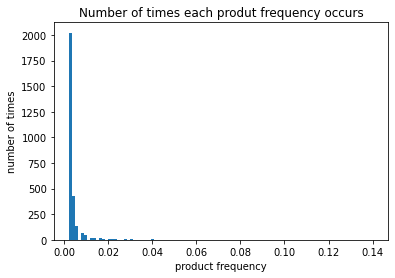

In [0]:
plt.hist(product_frequency, bins = 100);
plt.title('Number of times each produt frequency occurs');
plt.xlabel('product frequency');
plt.ylabel('number of times');

The values are concentrated in the left side (lower range). Let me zoom in the y axis to have a better idea of their count.

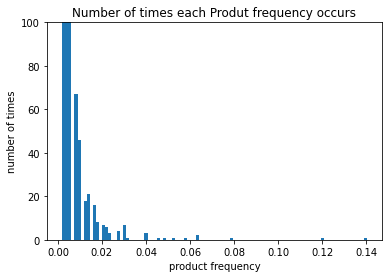

In [0]:
plt.hist(product_frequency, bins = 100);
plt.title('Number of times each Produt frequency occurs');
plt.xlabel('product frequency');
plt.ylabel('number of times');
plt.ylim([0, 100]);

In order to avoid including the products purchased only rarely, I will here set the minimum support equal to `0.01`, which stands for the products bought at least 4 times. I will then filter the products that fit this threshold to a new dataframe.

In [0]:
min_support = 0.01
products_apriori = product_frequency[product_frequency >= min_support]
print(products_apriori)

24852    0.140281
13176    0.120240
21903    0.078156
21137    0.064128
47209    0.064128
           ...   
12276    0.010020
35503    0.010020
31343    0.010020
40332    0.010020
41658    0.010020
Name: product_id, Length: 149, dtype: float64


There are 149 products remaining. In this example, it means a 95% reduction in the relevant data amount, which will clearly make computations easier.

Now let me get a new transactions dataframe containing only these products.

In [0]:
transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
print(transactions_apriori)

      order_id  product_id
0            2       33120
1            2       28985
5            2       17794
10           3       24838
12           3       21903
...        ...         ...
4975       526        1940
4982       527       49235
4988       527       21903
4989       527       35939
4992       527       17461

[1429 rows x 2 columns]


The transactions were reduced from 5,000 to 1,429 (71%).

I will now check the order sizes.

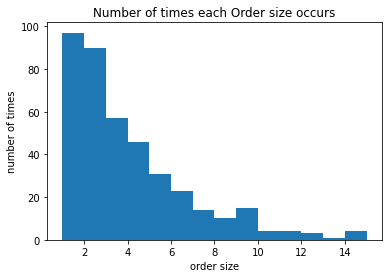

In [0]:
order_sizes = transactions_apriori.order_id.value_counts()
plt.hist(order_sizes, bins = max(order_sizes) - min(order_sizes));
plt.title('Number of times each Order size occurs');
plt.xlabel('order size');
plt.ylabel('number of times');

This tells me that most orders have 1 or 2 products. Since it makes no sense to make association rules with only 1 product, I can discard them. Then, I can also here establish the minimum length of the itemsets to be considered. If I set this value to, say, 4, it also makes no sense to include the orders with 3 products or less.

For this implementation, I will set the minimum length equals to `2`. 

In [0]:
min_length = 2
orders_apriori = order_sizes[order_sizes >= min_length]
print(orders_apriori)

431    15
493    15
265    14
426    14
359    13
       ..
211     2
196     2
208     2
436     2
293     2
Name: order_id, Length: 302, dtype: int64


There are 302 orders left (reduction of 39%).

In [0]:
transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
print(transactions_apriori)

      order_id  product_id
0            2       33120
1            2       28985
5            2       17794
10           3       24838
12           3       21903
...        ...         ...
4975       526        1940
4982       527       49235
4988       527       21903
4989       527       35939
4992       527       17461

[1332 rows x 2 columns]


There are 1,332 transactions left (73% reduction from the initial dataset).

Now I can start the second part of the algorithm, that deals with making product combinations. Differently from the basic algorithm though, I will not make every possible combinations, since many of them do not exist in the dataset. Instead, I will make all possible combinations inside each order, then at the end count them. This way, I can avoid the computation necessary to make combinations that will end up with a count equal to zero.

First let me demonstrate the idea. I will group the transactions by `order_id`, then get the order list retrieving the variable `product_id`. Then, for each order, I will generate all possible combinations. In this demonstration, I will limit the number of products in each combinations to 2.

In [0]:
transactions_by_order = transactions_apriori.groupby('order_id')['product_id']
for order_id, order_list in transactions_by_order:
    print('Order_id:', order_id, '\nOrder_list: ', list(order_list))
    product_combinations = combinations(order_list, 2)
    print('Product combinations:')
    print([i for i in product_combinations])
    print('\n')

Order_id: 2 
Order_list:  [33120, 28985, 17794]
Product combinations:
[(33120, 28985), (33120, 17794), (28985, 17794)]


Order_id: 3 
Order_list:  [24838, 21903, 46667, 17461]
Product combinations:
[(24838, 21903), (24838, 46667), (24838, 17461), (21903, 46667), (21903, 17461), (46667, 17461)]


Order_id: 5 
Order_list:  [13176, 27966, 23909, 6184, 37011, 47209]
Product combinations:
[(13176, 27966), (13176, 23909), (13176, 6184), (13176, 37011), (13176, 47209), (27966, 23909), (27966, 6184), (27966, 37011), (27966, 47209), (23909, 6184), (23909, 37011), (23909, 47209), (6184, 37011), (6184, 47209), (37011, 47209)]


Order_id: 9 
Order_list:  [21405, 14992, 31506, 432]
Product combinations:
[(21405, 14992), (21405, 31506), (21405, 432), (14992, 31506), (14992, 432), (31506, 432)]


Order_id: 10 
Order_list:  [24852, 31717, 47766, 4605, 21137, 27156, 14992, 49235]
Product combinations:
[(24852, 31717), (24852, 47766), (24852, 4605), (24852, 21137), (24852, 27156), (24852, 14992), (24852

Let me explain what happened with the last order, 527.

This order contains 4 products, printed above. With these 4 products, there are 6 possible combinations, also printed. 

The idea is to concatenate all combinations from all order, then count the number of occurences.

For implementing this, I will create a function, where I will consider three other things. First, before making combinations I will sort the `product_id`s  in `order_list`, to avoid having combinations of the kind [a, b]  counted separately from [b, a], while they mean the same thing. Second, I will not limit the length of combinations to 2, I will instead generate all combinations with length from 2 to a chosen `max_length`, which I will standardize to 5. Third, this function will not **return** all combinations, but instead **yield** one combination at a time. This implementation turns this function into a **generator**. I will then show what exactly happens when we make use of generators.  

In [0]:
def product_combinations(transactions_df, max_length = 5):
    transactions_by_order = transactions_df.groupby('order_id')['product_id']
    max_length_reference = max_length
    for order_id, order_list in transactions_by_order:
        # in case order_list is shorter than max_length, then update max_length to be equal to the length of order_list,
        # since we cannot make combinations of (for example) 5 elements from lists with 4, 3, 2 or 1 elements.
        max_length = min(max_length_reference, len(order_list))
        order_list = sorted(order_list)
        # now let me generate combinations containing from 2 to max_length elements
        for l in range(2, max_length + 1):
            product_combinations = combinations(order_list, l)
            for combination in product_combinations:
                yield combination

We can call an element of the generator by first instantiating it, then casting it to an `iter`ator, then finally calling the `next` element.

In [0]:
combs = product_combinations(transactions_apriori)
next(iter(combs))

(17794, 28985)

This is the very first combination generated based on the `transactions_apriori` dataframe.

The beauty of generators is that, differently from regular functions, they keep track of their internal state, so that, if I call the `next` function again, it will spit out the second combination.

In [0]:
next(iter(combs))

(17794, 33120)

And repeating it 100 more times.

In [0]:
for _ in range(100):
    print(next(iter(combs)))

(28985, 33120)
(17794, 28985, 33120)
(17461, 21903)
(17461, 24838)
(17461, 46667)
(21903, 24838)
(21903, 46667)
(24838, 46667)
(17461, 21903, 24838)
(17461, 21903, 46667)
(17461, 24838, 46667)
(21903, 24838, 46667)
(17461, 21903, 24838, 46667)
(6184, 13176)
(6184, 23909)
(6184, 27966)
(6184, 37011)
(6184, 47209)
(13176, 23909)
(13176, 27966)
(13176, 37011)
(13176, 47209)
(23909, 27966)
(23909, 37011)
(23909, 47209)
(27966, 37011)
(27966, 47209)
(37011, 47209)
(6184, 13176, 23909)
(6184, 13176, 27966)
(6184, 13176, 37011)
(6184, 13176, 47209)
(6184, 23909, 27966)
(6184, 23909, 37011)
(6184, 23909, 47209)
(6184, 27966, 37011)
(6184, 27966, 47209)
(6184, 37011, 47209)
(13176, 23909, 27966)
(13176, 23909, 37011)
(13176, 23909, 47209)
(13176, 27966, 37011)
(13176, 27966, 47209)
(13176, 37011, 47209)
(23909, 27966, 37011)
(23909, 27966, 47209)
(23909, 37011, 47209)
(27966, 37011, 47209)
(6184, 13176, 23909, 27966)
(6184, 13176, 23909, 37011)
(6184, 13176, 23909, 47209)
(6184, 13176, 27966, 3

Now I can see that some combinations are 2, 3, 4 or 5 products long. This is because I set `max_length = 5`, meaning I am building all combinations in the range 2 to 5.

And how can I apply this generator to the task at hand? Well, I can count all combinations occurrences without having to accumulate them first! This is done by calling function `Counter` with the generator. By doing this, `Counter` retrieves one element at a time and updates the count, which is kept over the whole process, but then discards the element, allocating the next one in its place. For dataset so large as this I am working with, this saves a lot of memory usage.

Before calling `Counter`, I need to first reset the generator by instantiating it again.

In [0]:
combs = product_combinations(transactions_apriori)
counter = Counter(combs).items() # `items()` will give me the counts in tuple form instead of a dictionary
combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter]) # the first element in the tuple is the count, the second is the combination
combinations_frequency = combinations_count / n_orders
print(combinations_frequency)

(17794, 28985)                  0.006012
(17794, 33120)                  0.002004
(28985, 33120)                  0.002004
(17794, 28985, 33120)           0.002004
(17461, 21903)                  0.004008
                                  ...   
(17461, 21903, 35939)           0.002004
(17461, 21903, 49235)           0.002004
(17461, 35939, 49235)           0.002004
(21903, 35939, 49235)           0.002004
(17461, 21903, 35939, 49235)    0.002004
Length: 41452, dtype: float64


There you have it! From those 1,332 transactions, we got 41,452 possible combinations with the parameters set above.

I would also like to check the range of combinations counts.

In [0]:
min(combinations_frequency), max(combinations_frequency)

(0.002004008016032064, 0.028056112224448898)

That means the least common combinations appear in 0.002 \* 499 = 1 order, and the most common appear in 0.028 \* 499 = 14 orders.

To comply with the algorithm, the combinations must also be filtered according to the `min_support` and `min_length` criteria.

In [0]:
combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
print(combinations_apriori, len(combinations_apriori))

(13176, 27966)    0.018036
(13176, 47209)    0.018036
(27966, 47209)    0.012024
(21137, 24852)    0.014028
(21137, 47766)    0.012024
(24852, 47766)    0.012024
(21903, 24852)    0.028056
(13176, 17794)    0.010020
(13176, 43352)    0.010020
(21903, 22935)    0.010020
(16797, 39275)    0.012024
(16797, 43352)    0.010020
(24852, 49683)    0.012024
(24852, 47626)    0.014028
(37646, 47209)    0.012024
(21903, 47209)    0.012024
(21137, 21903)    0.010020
(21137, 47209)    0.010020
(13176, 22935)    0.014028
(24852, 28204)    0.016032
(24852, 45066)    0.016032
(1158, 21903)     0.010020
(9076, 24852)     0.014028
(16797, 24852)    0.010020
(13176, 21137)    0.014028
(24852, 26209)    0.014028
(12341, 16797)    0.010020
dtype: float64 27


Only 27 combinations are remaining.

These combinations correspond to the `AB` itemsets, from which we have to derivate the rules. For this step, I will loop through every combination, then construct all possible rules. 

In [0]:
A = []
B = []
AB = []
for c in combinations_apriori.index:
    c_length = len(c) # The length of the original combination 
    # Since `A` and `B` must have at least one element, I will start by generating all possible new combinations having from 1
    # to `c_length`-1 elements. For example, if `c_length` = 3, then the new combinations (which will become `A`)
    # should have at least 1 element (leaving 2 for `B`) and at most 2 elements (leaving 1 for `B`).
    for l in range(1, c_length):
        comb = combinations(c, l)
        # For all new combination:
        for a in comb:
            # let me register the whole item set.
            AB.append(c)
            # `B` is all elements in the original combination...
            b = list(c)
            # ... from which we will remove the element already present in `A`.
            for e in a:
                b.remove(e)
            # Since `AB` is in tuple form, I will keep this as standard...
            b = tuple(b)
            # ... but retrieve only the element if the tuple has a single element.
            if len(a) == 1:
                a = a[0]
            A.append(a)
            if len(b) == 1:
                b = b[0]
            B.append(b)

In [0]:
apriori_df = pd.DataFrame({'A': A,
                           'B': B,
                           'AB': AB})
apriori_df.head()

,A,B,AB
0,13176,27966,"(13176, 27966)"
1,27966,13176,"(13176, 27966)"
2,13176,47209,"(13176, 47209)"
3,47209,13176,"(13176, 47209)"
4,27966,47209,"(27966, 47209)"


The next information I need to include is each element's *support*. The supports were already calculated (they mean the same as frequency), so I will first generate a dictionary containing all elements and their respective supports, both for each individual product and for each individual combination.



In [0]:
support = {**{k: v for k, v in products_apriori.items()}, 
           **{k: v for k, v in combinations_frequency.items()}}

I will use this dictionary to populate the previous dataframe with the supports for `A`, `B` and `AB`.

In [0]:
apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])

I will not be needing column `AB` anymore.

In [0]:
apriori_df.drop('AB', axis = 1, inplace = True)

All other relevant variables can be calculated from this information.

First, *confidence*.

In [0]:
apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A

Then *lift*.

In [0]:
apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B

I will now apply a final filter for `min_confidence` and `min_lift`.

In [0]:
min_confidence = 0.2
min_lift = 1.0
apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
apriori_df = apriori_df[apriori_df.lift >= min_lift]

Then, sorting the resulting dataframe by *lift*.

In [0]:
apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)

The last step is to convert `product_id`s to `product_name`s. I will use a function for that.

In [0]:
def convert_product_id_to_name(product_ids):
    # If `product_ids` contains only one element, than it is an integer
    if type(product_ids) == int:
        return products_id_to_name[product_ids]
    # Otherwise, it is a tuple. In this case, I will loop through the tuple and get all names.
    names = []
    for prod in product_ids:
        name = products_id_to_name[prod]
        names.append(name)
    names = tuple(names)
    return names

Finally, applying the function to update features `A` and `B`.

In [0]:
apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)
apriori_df

,A,B,support_A,support_B,support_AB,confidence,lift
0,Hass Avocados,Strawberries,0.018036,0.058116,0.010020,0.555556,9.559387
1,Mango Chunks,Organic Baby Spinach,0.014028,0.078156,0.010020,0.714286,9.139194
2,Organic Gala Apples,Organic Hass Avocado,0.022044,0.064128,0.012024,0.545455,8.505682
3,Strawberries,Organic Blueberries,0.058116,0.028056,0.012024,0.206897,7.374384
4,Organic Blueberries,Strawberries,0.028056,0.058116,0.012024,0.428571,7.374384
5,Raspberries,Strawberries,0.030060,0.058116,0.010020,0.333333,5.735632
6,Organic Raspberries,Organic Hass Avocado,0.040080,0.064128,0.012024,0.300000,4.678125
7,Blueberries,Banana,0.022044,0.140281,0.014028,0.636364,4.536364
8,Organic Avocado,Organic Strawberries,0.048096,0.064128,0.012024,0.250000,3.898438
9,Organic Fuji Apple,Banana,0.030060,0.140281,0.016032,0.533333,3.801905


And it is done!

I will not explore these results as they refer to the subset we used to establish the pipeline. Instead, I will group all relevant code into a function, to make future calculations easier. I will include some printouts throughtout the operation so that I can have an idea about how far down the process is.

#### Writing a function to make the job

In [0]:
def association_rules(order_products, min_support, min_length = 2, max_length = 5, min_confidence = 0.2, min_lift = 1.0):
    
    print('Loading data...')
    transactions_df = order_products[['order_id', 'product_id']]

    print('Calculating product supports...')
    n_orders = len(set(transactions_df.order_id))
    product_frequency = transactions_df.product_id.value_counts()/n_orders
    products_apriori = product_frequency[product_frequency >= min_support]
    transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
    
    order_sizes = transactions_apriori.order_id.value_counts()
    orders_apriori = order_sizes[order_sizes >= min_length]
    transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
    
    print('Calculating product combinations and supports...')
    
    def product_combinations(transactions_df, max_length = max_length):
        transactions_by_order = transactions_df.groupby('order_id')['product_id']
        max_length_reference = max_length
        for order_id, order_list in transactions_by_order:
            max_length = min(max_length_reference, len(order_list))
            order_list = sorted(order_list)
            for l in range(2, max_length + 1):
                product_combinations = combinations(order_list, l)
                for combination in product_combinations:
                    yield combination
   
    combs = product_combinations(transactions_apriori)
    counter = Counter(combs).items()
    combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
    combinations_frequency = combinations_count/n_orders
    combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
    combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
    
    print('Populating dataframe...')
    A = []
    B = []
    AB = []
    for c in combinations_apriori.index:
        c_length = len(c)
        for l in range(1, c_length):
            comb = combinations(c, l)
            for a in comb:
                AB.append(c)
                b = list(c)
                for e in a:
                    b.remove(e)
                b = tuple(b)
                if len(a) == 1:
                    a = a[0]
                A.append(a)
                if len(b) == 1:
                    b = b[0]
                B.append(b)
            
    apriori_df = pd.DataFrame({'A': A,
                               'B': B,
                               'AB': AB})
    support = {**{k: v for k, v in products_apriori.items()}, 
               **{k: v for k, v in combinations_frequency.items()}}
    apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
    apriori_df.drop('AB', axis = 1, inplace = True)
    apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A
    apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
    apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
    apriori_df = apriori_df[apriori_df.lift >= min_lift]
    apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
    
    def convert_product_id_to_name(product_ids):
        if type(product_ids) == int:
            return products_id_to_name[product_ids]
        names = []
        for prod in product_ids:
            name = products_id_to_name[prod]
            names.append(name)
        names = tuple(names)
        return names
    
    apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)

    print('{} rules were generated'.format(len(apriori_df)))

    return apriori_df

Now I can test the function with the whole dataset, as well as consider other parameters.

#### Applying the function

Now, even though I took measures to deal with memory issues, it is important to explore the solution space by small chunks, with limiting parameters, otherwise even a quite robust system might crasy.

Every call to the funciton will take a while, let me register how long it takes.

In [0]:
start = datetime.now()
rules = association_rules(order_products, min_support = 0.01)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
11 rules were generated
Execution time:  0:07:41.247906


In [0]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Raspberries,Organic Strawberries,0.042632,0.082331,0.010533,0.247072,3.000973
1,Organic Fuji Apple,Banana,0.027880,0.146993,0.010558,0.378693,2.576259
2,Organic Raspberries,Bag of Organic Bananas,0.042632,0.118030,0.012599,0.295519,2.503775
3,Organic Hass Avocado,Bag of Organic Bananas,0.066436,0.118030,0.019391,0.291880,2.472945
4,Organic Avocado,Banana,0.054999,0.146993,0.016609,0.301982,2.054395
5,Organic Strawberries,Bag of Organic Bananas,0.082331,0.118030,0.019170,0.232837,1.972702
6,Strawberries,Banana,0.044466,0.146993,0.012825,0.288434,1.962229
7,Large Lemon,Banana,0.047485,0.146993,0.012716,0.267790,1.821783
8,Organic Baby Spinach,Bag of Organic Bananas,0.075251,0.118030,0.015668,0.208217,1.764107
9,Organic Baby Spinach,Banana,0.075251,0.146993,0.015987,0.212445,1.445272


With a minimum support of 0.01, the strongest relationship is between organic raspberries and organic strawberries. 25% of users who buy raspberries do also buy strawberries. All other association rules with these criteria involve some produce and bananas. The largest confidence, 38%, is between fuji apple and banana. The lift is not so high though, ranging from 1.4 to 2.6.

It is also noteworthy that, even though the rules output combinations of the most commonly purchased products, their support is lower than 0.02. That means that all other combinations of two products will be present in less than 2% of all orders. Combinations of three or more will more much rarer.

In [0]:
start = datetime.now()
rules = association_rules(order_products, min_support = 0.005, max_length = 4)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
37 rules were generated
Execution time:  0:13:48.085406


In [0]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Cilantro,Limes,0.021626,0.043743,0.005464,0.252647,5.775753
1,Organic Garlic,Organic Yellow Onion,0.034147,0.035282,0.006866,0.201069,5.698983
2,Organic Lemon,Organic Hass Avocado,0.027294,0.066436,0.006609,0.242131,3.644560
3,Organic Cucumber,Organic Hass Avocado,0.025006,0.066436,0.005430,0.217136,3.268339
4,Organic Raspberries,Organic Strawberries,0.042632,0.082331,0.010533,0.247072,3.000973
5,Organic Blueberries,Organic Strawberries,0.031124,0.082331,0.007389,0.237418,2.883704
6,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023380,0.118030,0.007267,0.310836,2.633546
7,Organic Fuji Apple,Banana,0.027880,0.146993,0.010558,0.378693,2.576259
8,Organic Raspberries,Bag of Organic Bananas,0.042632,0.118030,0.012599,0.295519,2.503775
9,Organic Cucumber,Organic Strawberries,0.025006,0.082331,0.005150,0.205928,2.501234


To explore a lower support of 0.005, I had to limit `max_length` to 4. Nevertheless, all solutions presented are only 2 products long.

Besides the rules already presented before, we see some other produce combined with banana, as well as milk and banana. The are some lifts higher than 5, for cilantro and lime, and garlic and onion. The higher confidence, 38%, is that of fuji apple and banana.

In [0]:
start = datetime.now()
rules = association_rules(order_products, min_support = 0.002, max_length = 3)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
211 rules were generated
Execution time:  0:14:53.184669


In [0]:
rules.head(20)

,A,B,support_A,support_B,support_AB,confidence,lift
0,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.005990,0.005094,0.002247,0.375136,73.640837
1,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005094,0.005990,0.002247,0.441106,73.640837
2,Vanilla Skyr Nonfat Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005643,0.005990,0.002069,0.366718,61.222024
3,Icelandic Style Skyr Blueberry Non-fat Yogurt,Vanilla Skyr Nonfat Yogurt,0.005990,0.005643,0.002069,0.345485,61.222024
4,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt With Blu...,0.009298,0.006457,0.002902,0.312147,48.343394
5,Total 2% Lowfat Greek Strained Yogurt With Blu...,Total 2% with Strawberry Lowfat Greek Strained...,0.006457,0.009298,0.002902,0.449513,48.343394
6,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt with Peach,0.009298,0.006192,0.002493,0.268090,43.292848
7,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% with Strawberry Lowfat Greek Strained...,0.006192,0.009298,0.002493,0.402552,43.292848
8,Frozen Organic Wild Blueberries,Organic Whole Strawberries,0.009302,0.009781,0.002104,0.226149,23.121071
9,Organic Whole Strawberries,Frozen Organic Wild Blueberries,0.009781,0.009302,0.002104,0.215074,23.121071


With a minimum support of 0.002, 211 rules were generated. I am inspecting only the first 20.

The strongest association (lift 73) is between blueberry and raspberry non-fat yoghurt, followed by other paired flavors of yoghurt (lift 43-61). The highest confidence (45%) is also revolving yoghurts. Next, there are paired berries and peppers, then flavored sparkling water. Following, I notice what seems to be ingredientes for guacamole.  

In [0]:
start = datetime.now()
rules = association_rules(order_products, min_support = 0.001, max_length = 2)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
394 rules were generated
Execution time:  0:06:30.802523


In [0]:
rules.head(20)

,A,B,support_A,support_B,support_AB,confidence,lift
0,Non Fat Acai & Mixed Berries Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.002694,0.005990,0.001221,0.453129,75.647888
1,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Acai & Mixed Berries Yogurt,0.005990,0.002694,0.001221,0.203822,75.647888
2,Grapefruit Sparkling Water,Lemon Sparkling Water,0.004643,0.002954,0.001037,0.223406,75.634068
3,Lemon Sparkling Water,Grapefruit Sparkling Water,0.002954,0.004643,0.001037,0.351201,75.634068
4,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.005990,0.005094,0.002247,0.375136,73.640837
5,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005094,0.005990,0.002247,0.441106,73.640837
6,Nonfat Icelandic Style Strawberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.003317,0.005990,0.001418,0.427553,71.378186
7,Icelandic Style Skyr Blueberry Non-fat Yogurt,Nonfat Icelandic Style Strawberry Yogurt,0.005990,0.003317,0.001418,0.236745,71.378186
8,Non Fat Raspberry Yogurt,Nonfat Icelandic Style Strawberry Yogurt,0.005094,0.003317,0.001189,0.233315,70.344028
9,Nonfat Icelandic Style Strawberry Yogurt,Non Fat Raspberry Yogurt,0.003317,0.005094,0.001189,0.358342,70.344028


Finally, with a minimum support of 0.001 and a maximum length of 2, 394 rules were returned. From the top 20, the relationship between yoghurt types and some kinds of sparkling water is reinforced. Lifts are as high as 76, and the confidence is up to 45%. I suspect users tend to purchase more than one flavor at once, opting for diverse tastes. If the retailer was willing to promote a new yoghurt product, they could sell it promotionally along another youghurt product. 

## 6 Conclusion

Large datasets are a data scientist dream. In the case of association rules, besides granting statistical power, they allow us to find rare relationships that we would not be able to find otherwise. This exercise let me dive into the world of retailing, exploring the habits of clients of a grocery shop. I determined rules associating purchase habits (such as order size, day and hour of purchase, interval between orders) and products. For this last one, I had to code the algorithm by hand, so that it could deal with the large amount of data with constraining memory availability. From these rules, I suggested some approaches with strategic value, showcasing a practical application of this type of machine learning.